# Team Members:
> - Seif Yasser
> - Mohammed Yasser
> - Omar Ahmed

In [1]:
import os
import math
import torch
import random
import pandas as pd
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter



2025-04-29 00:57:55.743121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745888275.949892      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745888276.010845      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# BATCH_SIZE = 32
# LEARNING_RATE = 0.001
EPOCHS = 100
NUM_CLASSES = 7
BETAS=(0.5 , 0.999)

In [ ]:
# Model_trainingmethod_optimizer_lr_scheduler_batch_size_lossfn_weightdecay
run_names = ['Custom_Naive_adam_0.001_None_32_crossentropy_wd0'
  , 'Custom_Naive_adam_0.001_None_32_KLDivLoss_wd0'
  , 'Custom_Naive_adam_0.001_None_32_svm_wd0'

  , 'Custom_Naive_sgd_0.001_step_32_crossentropy_wd0'
  , 'Custom_Naive_sgd_0.001_cosine_32_crossentropy_wd0'

  , 'Custom_Naive_rmsprop_0.1_None_32_crossentropy_wd0'
  , 'Custom_Naive_rmsprop_0.01_None_32_crossentropy_wd0'
  , 'Custom_Naive_rmsprop_0.1_None_16_crossentropy_wd0'
  , 'Custom_Naive_rmsprop_0.01_None_16_crossentropy_wd0'

  , 'Custom_Naive_adagrad_0.01_None_32_crossentropy_wd1e-6'
  , 'Custom_Naive_adagrad_0.01_None_32_crossentropy_wd1e-7'

  , 'ResNet_Transfer_Adam_0.01_None_32_crossentropy_wd0'
  , 'ResNet_Naive_Adam_0.01_None_32_crossentropy_wd0'

  , 'AlexNet_Transfer_Adam_0.01_None_32_crossentropy_wd0'
  , 'AlexNet_Naive_Adam_0.01_None_32_crossentropy_wd0'
  , 'GoogLeNet_Transfer_Adam_0.01_None_32_crossentropy_wd0'
  , 'GoogLeNet_Naive_Adam_0.01_None_32_crossentropy_wd0'
  , 'VGG16_Transfer_Adam_0.01_None_32_crossentropy_wd0'
  , 'VGG16_Naive_Adam_0.01_None_32_crossentropy_wd0'
  , 'VGG19_Transfer_Adam_0.01_None_32_crossentropy_wd0'
  , 'VGG19_Naive_Adam_0.01_None_32_crossentropy_wd0']

In [4]:
# dataset_path = '../data/sidharkal-sports-image-classification/dataset'
dataset_path = "/kaggle/input/sports-image-classification/dataset"

In [5]:
class SportsDataset(Dataset):
    def __init__(self, csv_file, file_path, split='train', transform=None):

        self.data_info = pd.read_csv(csv_file)
        self.root_dir = os.path.join(file_path, split)
        self.transform = transform
        self.split = split
        # Build string → index mapping from all labels in this split
        if split == 'train':
            label_column = self.data_info.iloc[:, 1]  # assuming 2nd column is the label
            classes = sorted(label_column.unique())
            self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
            print(f"Classes: {self.class_to_idx}")

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        # 1) Load image
        img_name = os.path.join(self.root_dir, self.data_info.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        # 2) Apply transforms
        if self.transform:
            image = self.transform(image)

        if self.split=='train':
        # 3) String label → integer index
            label_str = self.data_info.iloc[idx, 1]
            label_idx = self.class_to_idx[label_str]

            # 4) Return image tensor, label tensor
            return image, torch.tensor(label_idx, dtype=torch.int8)
        else:
            # 3) Return image tensor, label tensor
            return image


In [6]:
train_csv_path= os.path.join(dataset_path, 'train.csv')
test_csv_path= os.path.join(dataset_path, 'test.csv')

In [7]:
data_csv = pd.read_csv(train_csv_path)

In [8]:
data_csv['label'].nunique() # 7 classes

7

In [9]:
label_counts = data_csv['label'].value_counts()


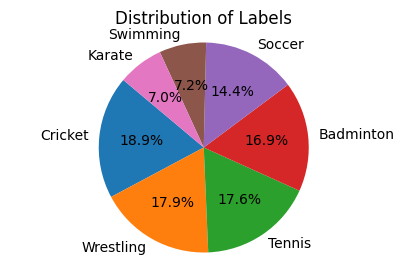

In [10]:
plt.figure(figsize=(5, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')
plt.axis('equal') 
plt.show()

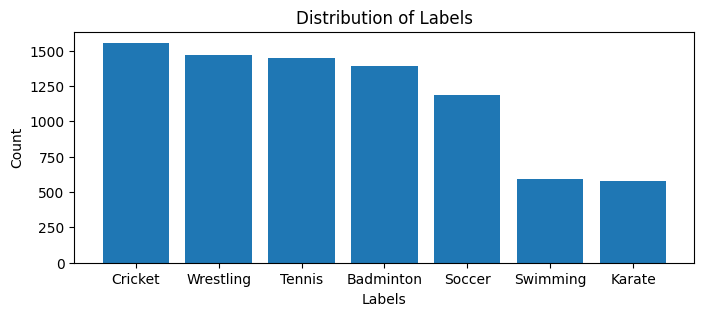

In [11]:
plt.figure(figsize=(8, 3))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

In [12]:
transforms = transforms.Compose([

    transforms.RandomResizedCrop(
        224,
        scale=(0.8, 1.0),
        ratio=(0.75, 1.3333)
    ),

    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),

    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    # transforms.Resize((224, 224)),  # remove if RandomResizedCrop already gives 224×224
    transforms.ToTensor(),

    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [13]:
# train_dataset = SportsDataset(csv_file=train_csv_path, file_path=dataset_path, split='train', transform=transforms)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [14]:
# test_dataset = SportsDataset(csv_file=test_csv_path, file_path=dataset_path, split='test', transform=transforms)

# val_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [15]:
def show_tensor_images(image_tensor):
    # Detach tensor and ensure it's on CPU, then take the first image if batch exists
    img = image_tensor.detach().cpu()
    
    # If the image has a single channel, treat it as grayscale
    if img.dim() == 2 or img.shape[0] == 1:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        # If image is normalized (using the usual ImageNet means and stds), de-normalize it
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = img.clamp(0, 1)
        # Convert tensor (C, H, W) → (H, W, C) for RGB plotting
        plt.imshow(img.permute(1, 2, 0))
    
    plt.axis("off")
    plt.show()

In [16]:
# show_tensor_images(train_loader.dataset[5][0])

In [17]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,act='relu',drop=False,norm=True):
        super().__init__()
        self.drop=drop
        self.norm=norm
        self.dropout=nn.Dropout(0.5)
        if self.norm==True:
            self.block=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,4,2,1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
            )
        else:
            self.block=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,4,2,1),
                nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
            )
    def forward(self,x):
        x=self.block(x)
        return self.dropout(x) if self.drop else x

In [18]:
def calc_ouput_size(input_size, kernel_size, stride, padding):
    return (input_size - kernel_size + 2 * padding) // stride + 1

In [19]:
calc_ouput_size(224, 4, 2, 1)

112

In [20]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=7, input_channels=3, input_size=(224, 224),dropout=0.5,hidden_dim=64):
        super(CustomCNN, self).__init__()
        self.conv1 = Block(input_channels, hidden_dim, act='relu', drop=False, norm=False) # 3x224x224 -> 64x112x112
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 64x112x112 -> 64x56x56
        self.conv2 = Block(hidden_dim, hidden_dim, act='relu', drop=False, norm=False) # 64x56x56 -> 64x28x28
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64x28x28 -> 64x14x14
        self.conv3 = Block(hidden_dim, hidden_dim*2, act='relu', drop=False, norm=False)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 64x14x14 -> 128x7x17
        self.conv4 = Block(hidden_dim*2, hidden_dim*2, act='relu', drop=False, norm=False) # 128x7x7 -> 128x3x3
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 128x7x7 -> 128x3x3
        self.fc1 = nn.Linear(128, 128)  #  128x3x3 -> 128
        self.relu=nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, num_classes) # 128 -> num_classes
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [21]:
def xavier_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
            

def kaiming_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

def msra_init(m):
    # MSRA is another name for kaiming initialization
    # but often focuses on fan_in mode specifically
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

def custom_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm3d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [22]:
def init_weights(model, init_type='xavier'):
    if init_type == 'xavier':
        model.apply(xavier_init)
    elif init_type == 'kaiming':
        model.apply(kaiming_init)
    elif init_type == 'msra':
        model.apply(msra_init)
    elif init_type == 'custom':
        model.apply(custom_init)
    else:
        raise ValueError(f"Unknown initialization type: {init_type}")

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
    
    def __call__(self, val_loss, model, path='checkpoint.pt'):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model, path):
        """Save model when validation loss decreases."""
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss


In [25]:
def initialize_model(model_class=CustomCNN, num_classes=NUM_CLASSES, input_channels=3, input_size=(224, 224), dropout=0.5, hidden_dim=64,pretrained_weights=None, weight_init_method='custom'):
    # classifier=CustomCNN(num_classes=NUM_CLASSES, input_channels=3, input_size=(224, 224),dropout=0.5,hidden_dim=64)
    model = model_class(num_classes=num_classes, input_channels=input_channels, input_size=input_size, dropout=dropout, hidden_dim=hidden_dim)
    if pretrained_weights:
        model.load_state_dict(torch.load(pretrained_weights))
    else:
        init_weights(model, init_type=weight_init_method)
    model.to(device)
    return model

In [26]:
def initialize_optimizer(model,optimizer, learning_rate=0.001, betas=(0.9, 0.999), weight_decay=0.0001):
    if optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas)
    elif optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer=="rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=weight_decay, centered=False)
    elif optimizer == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, lr_decay=0, weight_decay=weight_decay, initial_accumulator_value=0, eps=1e-10)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")
    return optimizer

In [27]:
def initialize_loss_function(loss_fn='crossentropy'):
    if loss_fn == 'crossentropy':
        criterion = nn.CrossEntropyLoss()
    elif loss_fn == 'KLDivLoss':
        criterion = nn.KLDivLoss(reduction='batchmean')
    elif loss_fn == 'svm':
        criterion=nn.MultiMarginLoss(margin=1.0)
    else:
        raise ValueError(f"Unknown loss function: {loss_fn}")
    criterion.to(device)
    return criterion

In [28]:
def initialize_lr_scheduler(optimizer, scheduler_type='step', step_size=10, gamma=0.1):
    if scheduler_type == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    elif scheduler_type == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0)
    elif scheduler_type=='linear':
        scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=EPOCHS)
    else:
        raise ValueError(f"Unknown scheduler type: {scheduler_type}")
    return scheduler

In [29]:
def initialize_tensorboard_writer(log_directory, run_name):
    # Create a directory for the logs if it doesn't exist
    os.makedirs(log_directory, exist_ok=True)
    
    # Initialize the SummaryWriter
    writer = SummaryWriter(log_dir=os.path.join(log_directory, run_name))
    return writer

In [30]:
def initialize_early_stopping(patience=5, delta=0):
    early_stopping = EarlyStopping(patience=patience, delta=delta)
    return early_stopping

In [31]:
def initialize_data_loaders(train_csv_path, test_csv_path, dataset_path, transforms):
    train_dataset = SportsDataset(csv_file=train_csv_path, file_path=dataset_path, split='train', transform=transforms)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataset = SportsDataset(csv_file=test_csv_path, file_path=dataset_path, split='test', transform=transforms)

    val_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    return train_loader, val_loader

In [32]:
def draw_save_graph(model, name='custom_arch_graph'):
    # Create the directory if it doesn't exist
    graph_dir = 'models/graphs'
    os.makedirs(graph_dir, exist_ok=True)
    
    # Create full path for the graph
    path = os.path.join(graph_dir, name)
    
    # Create a graph of the model
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    dot = make_dot(model(sample_input), params=dict(list(model.named_parameters())))
    
    # Save the graph as a PNG file
    dot.format = 'png'
    dot.render(filename=path, cleanup=True)
    print(f"Graph saved to {path}.png")

In [ ]:
def initialize_all(run_name='custom_arch_graph',model_class=CustomCNN, num_classes=NUM_CLASSES, input_channels=3, input_size=(224, 224), dropout=0.5, hidden_dim=64,betas=BETAS, optimizer='adam', learning_rate=0.001, weight_decay=0.0001,loss_fn='crossentropy',scheduler_type=None,log_directory='logs'):
    train_loader, val_loader=initialize_data_loaders(train_csv_path, test_csv_path, dataset_path, transforms)
    criterion=initialize_loss_function(loss_fn=loss_fn)
    model=initialize_model(model_class, num_classes, input_channels, input_size, dropout, hidden_dim)
    # draw_save_graph(model,name=run_name)
    optimizer=initialize_optimizer(model,optimizer,learning_rate=learning_rate,betas=betas,weight_decay=weight_decay)
    if scheduler_type:
        scheduler=initialize_lr_scheduler(optimizer, scheduler_type=scheduler_type, step_size=25, gamma=0.1)
    else:
        scheduler=None
    writer=initialize_tensorboard_writer(log_directory, run_name)
    early_stopping=initialize_early_stopping()
    
    return model, optimizer, criterion, scheduler, writer, early_stopping, train_loader, val_loader
    # initialize_checkpoint_manager()
    # initialize_logger()

In [34]:
def save_model(run_name,model,epoch,optimizer,train_loss,batch_size=32,lr=0.01,num_classes=7):
    batch_size=int(run_name.split('_')[5])
    lr=float(run_name.split('_')[3])
    checkpoint_path = f'models/checkpoints/model{run_name}_epoch_{epoch+1}.pth'
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'hyperparameters': {
            'BATCH_SIZE': batch_size,
            'LEARNING_RATE': lr,
            # 'BETAS': betas,
            'NUM_CLASSES': num_classes
        },
        'loss': train_loss,
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")

In [35]:
list(range(0,1))

[0]

In [36]:
def plot_loss_acc(run_name,epoch,losses, accuracies):
    print(losses)
    print(epoch+1)
    # Plot and save the training curves
    os.makedirs('logs/plots', exist_ok=True)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch+2), losses)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch+2), accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.savefig(f'logs/plots/training_curves_{run_name}_{epoch+1}.png')
    plt.show()

In [ ]:
def training_loop(run_name, num_epochs, model, train_loader, optimizer, criterion, device, writer, scheduler=None):
    losses = []
    accuracies = []
    os.makedirs('logs/plots', exist_ok=True)
    
    for epoch in range(num_epochs):
        # ----- Training -----
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        prog_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for images, labels in prog_bar:
            images = images.to(device)
            labels = labels.to(device).long()
            
            optimizer.zero_grad()
            outputs = model(images)
            if isinstance(criterion, nn.KLDivLoss):
                outputs = outputs.float()
                input_log_probs = F.log_softmax(outputs, dim=1)  # apply over classes
                # One-hot encode labels
                target_probs = F.one_hot(labels, num_classes=7).float()
                loss = criterion(input_log_probs, target_probs)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            prog_bar.set_postfix({'loss': loss.item()})
            
            writer.add_scalar('Loss/Train_Batch', loss.item(), epoch)
            
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train
        
        # Step the scheduler after each epoch if it exists
        if scheduler is not None:
            scheduler.step()
            writer.add_scalar('Learning_Rate', scheduler.get_last_lr()[0], epoch)
        
        losses.append(train_loss)
        accuracies.append(train_acc)

        # ----- Validation -----
        model.eval()
        
        print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss:.4f}, "
            f"Train Acc: {train_acc:.4f}")
        
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_acc, epoch)
        
        # Save model every 25 epochs
        if (epoch + 1) % 25 == 0:
            save_model(run_name, model, epoch, optimizer, train_loss, num_classes=7)
            plot_loss_acc(run_name, epoch, losses, accuracies)


In [38]:
def log_hyperparameters(writer, hyperparameters_dict):
    writer.add_hparams(
        hparam_dict= hyperparameters_dict,
        metric_dict={
        }
    )

In [39]:
log_directory = 'logs'

train_model -> initialize_all -> log_hyperparameters -> training_loop -> save_model

In [ ]:
def train_model(class_model,model_name,optimizer, criterion, num_epochs=100,batch_size=32,learning_rate=0.01,betas=(0.9, 0.999),loss_fn='crossentropy', device='cuda',num_classes=7,weight_decay=0.0001,scheduler_type='step'):

    model, optimizer, criterion, scheduler, writer, early_stopping, train_loader, val_loader = initialize_all(
        run_name=model_name,
        model_class=class_model,
        num_classes=num_classes,
        input_channels=3,
        input_size=(224, 224),
        dropout=0.5,
        hidden_dim=64,
        betas=betas,
        optimizer=optimizer,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        loss_fn=loss_fn,
        scheduler_type=scheduler_type
    )
    hyperparameters_dict={
        "BATCH_SIZE":     batch_size,
            "LEARNING_RATE":  learning_rate,
            "EPOCHS":         num_epochs,
            "BETAS":          str(betas),
            "NUM_CLASSES":    num_classes,
    }
    log_hyperparameters(writer, hyperparameters_dict)
    
    training_loop(run_name=model_name,num_epochs=num_epochs, model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device,writer=writer, scheduler=scheduler)
    # save_model(model, path=f'../models/pretrained/{model_name}.pth', optimizer=optimizer)
    
    writer.close()

In [41]:
run_name=run_names[1]

In [42]:
def parse_run_name(run_name):
    architecture=run_name.split('_')[0]
    training_method=run_name.split('_')[1]
    optimizer=run_name.split('_')[2]
    learning_rate=float(run_name.split('_')[3])
    learning_scheduler=run_name.split('_')[4]=None if 'None' in run_name.split('_')[4] else run_name.split('_')[4] 
    batch_size=int(run_name.split('_')[5])
    loss_fn=run_name.split('_')[6]
    weight_decay=float(run_name.split('_')[7][2:])
    return architecture, training_method, optimizer, learning_rate, learning_scheduler, batch_size, loss_fn, weight_decay

In [43]:
architecture, training_method, optimizer, learning_rate, learning_scheduler, batch_size, loss_fn, weight_decay=parse_run_name(run_name)

In [ ]:
train_model(CustomCNN,run_name,optimizer=optimizer,criterion=loss_fn, num_epochs=EPOCHS,batch_size=batch_size,learning_rate=learning_rate,betas=BETAS,loss_fn=loss_fn, device=device,num_classes=NUM_CLASSES)

Classes: {'Badminton': 0, 'Cricket': 1, 'Karate': 2, 'Soccer': 3, 'Swimming': 4, 'Tennis': 5, 'Wrestling': 6}


Epoch 1/2:  73%|███████▎  | 189/258 [01:48<00:42,  1.62it/s, loss=1.72]

In [ ]:
# model = CustomCNN(num_classes=7)
# model.to(device)


os.listdir("/kaggle/working/models/checkpoints")


In [ ]:
import shutil
import os

# Step 1: Create a ZIP archive of everything inside /kaggle/working/
shutil.make_archive('/kaggle/working/working_folder_backup', 'zip', '/kaggle/working')

# Step 2: Confirm that the zip file is created
if os.path.exists('/kaggle/working/working_folder_backup.zip'):
    print("✅ Archive created: working_folder_backup.zip")
else:
    print("❌ Failed to create archive.")

# Step 3: Now, manually download it:
# In the right sidebar ➔ Files ➔ Refresh ➔ Click 'working_folder_backup.zip' ➔ Download
